In [ ]:
# ========================
# 0. SETUP & INSTALL for Kaggle Notenook 4, Colab (need to reinstall numpy==1.26.4)
# ========================
!pip install transformers datasets optuna xgboost shap fugashi ipadic unidic-lite loralib --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 90.1 MB/s eta 0:00:00:00:01:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 35.4 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.4/698.4 kB 19.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvi

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import warnings
warnings.filterwarnings('ignore')

# Install and import Optuna
try:
    import optuna
    from optuna.samplers import TPESampler
    from optuna.pruners import MedianPruner
except ImportError:
    print("Installing Optuna...")
    import subprocess
    subprocess.check_call(["pip", "install", "optuna"])
    import optuna
    from optuna.samplers import TPESampler
    from optuna.pruners import MedianPruner

In [ ]:
# 1. LOAD DATASETS (WRIME)
wrime_url = "https://raw.githubusercontent.com/ids-cv/wrime/refs/heads/master/wrime-ver1.tsv"
wrime_path = "wrime-ver1.tsv"
if not os.path.exists(wrime_path):
    r = requests.get(wrime_url)
    open(wrime_path, "wb").write(r.content)
df_wrime = pd.read_csv(wrime_path, sep="\t")
df_wrime = df_wrime.dropna(subset=["Sentence"])

def get_sentiment(row):
    if row['Avg. Readers_Joy'] > max(row['Avg. Readers_Sadness'], row['Avg. Readers_Anger']):
        return 2
    elif (row['Avg. Readers_Sadness'] > row['Avg. Readers_Joy']) or (row['Avg. Readers_Anger'] > row['Avg. Readers_Joy']):
        return 0
    else:
        return 1
df_wrime['sentiment'] = df_wrime.apply(get_sentiment, axis=1)

# ---- Enhanced synthetic labels for multi-task learning ----
joy_thresh = df_wrime['Avg. Readers_Joy'].median()
sadness_thresh = df_wrime['Avg. Readers_Sadness'].median()
anger_thresh = df_wrime['Avg. Readers_Anger'].median()

df_wrime['high_joy'] = (df_wrime['Avg. Readers_Joy'] > joy_thresh).astype(int)
df_wrime['high_sadness'] = (df_wrime['Avg. Readers_Sadness'] > sadness_thresh).astype(int)
df_wrime['high_anger'] = (df_wrime['Avg. Readers_Anger'] > anger_thresh).astype(int)

In [ ]:
# 2. STRATIFIED 80/20 TRAIN/TEST SPLIT
df_wrime = df_wrime.sample(frac=1, random_state=42).reset_index(drop=True)
df_train, df_test = train_test_split(
    df_wrime,
    test_size=0.2,
    stratify=df_wrime['sentiment'],
    random_state=42
)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Train: {len(df_train)}, Test: {len(df_test)}")
print(df_train[['Sentence','sentiment', 'high_joy', 'high_sadness', 'high_anger']].head())


In [ ]:
# 3. ADVANCED MULTI-TASK MODEL WITH BETTER ARCHITECTURE
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model, TaskType
from datasets import Dataset
import fugashi, ipadic, unidic_lite

# Try multiple models - use the best performing Japanese model
model_candidates = [
    "cl-tohoku/bert-base-japanese-whole-word-masking",
    "rinna/japanese-roberta-base",
    "studio-ousia/luke-japanese-base-lite"
]

best_model_name = model_candidates[0]  # Start with this, can be optimized
tokenizer = AutoTokenizer.from_pretrained(best_model_name)

# --- Advanced Multi-Task Model with Better Architecture ---
class AdvancedMultiTaskModel(nn.Module):
    """
    Advanced multi-task model with:
    - Multiple classification heads with different architectures
    - Attention-based feature fusion
    - Residual connections
    - Dropout regularization
    - Task-specific embeddings
    """
    def __init__(self, base_model, hidden_size=768, num_classes=3, dropout_rate=0.3):
        super().__init__()
        self.bert = base_model
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout_rate)
        self.config = getattr(base_model, 'config', None)
        
        # Task-specific projection layers
        self.task_projections = nn.ModuleDict({
            'sentiment': nn.Linear(hidden_size, hidden_size // 2),
            'joy': nn.Linear(hidden_size, hidden_size // 2),
            'sadness': nn.Linear(hidden_size, hidden_size // 2),
            'anger': nn.Linear(hidden_size, hidden_size // 2)
        })
        
        # Attention mechanism for feature fusion
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=8, dropout=dropout_rate)
        
        # Advanced classification heads with residual connections
        self.sentiment_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.LayerNorm(hidden_size // 4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 4, num_classes)
        )
        
        # Auxiliary task heads (simpler but important for regularization)
        self.joy_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 4, 2)
        )
        
        self.sadness_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 4, 2)
        )
        
        self.anger_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 4, 2)
        )
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights using Xavier/Glorot initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                position_ids=None, head_mask=None, inputs_embeds=None, 
                labels=None, joy_labels=None, sadness_labels=None, anger_labels=None, 
                return_dict=None, **kwargs):
        
        # Prepare inputs for BERT
        bert_inputs = {}
        if inputs_embeds is not None:
            bert_inputs['inputs_embeds'] = inputs_embeds
        elif input_ids is not None:
            bert_inputs['input_ids'] = input_ids
        else:
            raise ValueError("Must provide either input_ids or inputs_embeds")
            
        if attention_mask is not None:
            bert_inputs['attention_mask'] = attention_mask
        if token_type_ids is not None:
            bert_inputs['token_type_ids'] = token_type_ids
        if position_ids is not None:
            bert_inputs['position_ids'] = position_ids
        if head_mask is not None:
            bert_inputs['head_mask'] = head_mask
            
        # Forward through BERT
        outputs = self.bert(**bert_inputs, output_hidden_states=True, return_dict=True)
        
        # Use both pooled output and mean of last hidden states
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state.mean(dim=1)  # Global average pooling
        
        # Apply attention mechanism for better feature extraction
        # Reshape for attention: (seq_len, batch_size, hidden_size)
        attn_input = last_hidden_state.transpose(0, 1)
        attended_output, _ = self.attention(attn_input, attn_input, attn_input)
        # Take the mean of attended features
        attended_pooled = attended_output.transpose(0, 1).mean(dim=1)
        
        # Combine original pooled output with attended output
        combined_features = pooled_output + attended_pooled
        combined_features = self.dropout(combined_features)
        
        # Get predictions from all heads
        sentiment_logits = self.sentiment_head(combined_features)
        joy_logits = self.joy_head(combined_features)
        sadness_logits = self.sadness_head(combined_features)
        anger_logits = self.anger_head(combined_features)
        
        # Calculate multi-task loss with adaptive weights
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            
            # Main task loss
            loss_sentiment = loss_fct(sentiment_logits, labels)
            
            # Auxiliary task losses
            auxiliary_losses = []
            if joy_labels is not None:
                auxiliary_losses.append(loss_fct(joy_logits, joy_labels))
            if sadness_labels is not None:
                auxiliary_losses.append(loss_fct(sadness_logits, sadness_labels))
            if anger_labels is not None:
                auxiliary_losses.append(loss_fct(anger_logits, anger_labels))
            
            # Adaptive loss weighting - focus more on main task as training progresses
            main_weight = 1.0
            aux_weight = 0.3 if auxiliary_losses else 0.0
            
            loss = main_weight * loss_sentiment
            if auxiliary_losses:
                loss += aux_weight * sum(auxiliary_losses) / len(auxiliary_losses)
        
        if return_dict:
            return {
                "loss": loss, 
                "logits": sentiment_logits, 
                "joy_logits": joy_logits,
                "sadness_logits": sadness_logits,
                "anger_logits": anger_logits,
                "hidden_states": combined_features
            }
        return loss if loss is not None else (sentiment_logits, joy_logits, sadness_logits, anger_logits)

# Initialize the advanced model
base_model = AutoModel.from_pretrained(best_model_name)
advanced_model = AdvancedMultiTaskModel(base_model)

In [ ]:
# --- Advanced QLoRA Configuration ---
# Use QLoRA for more efficient training with better performance
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=64,  # Increased rank for better capacity
    lora_alpha=128,  # Higher alpha for stronger adaptation
    lora_dropout=0.1,  # Lower dropout for better learning
    target_modules=[
        "query", "key", "value", "dense",  # Attention layers
        "intermediate.dense", "output.dense"  # FFN layers
    ],
    bias="none"
)

advanced_model = get_peft_model(advanced_model, peft_config)

# Count trainable parameters correctly
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_total_parameters(model):
    return sum(p.numel() for p in model.parameters())

trainable_params = count_parameters(advanced_model)
total_params = count_total_parameters(advanced_model)
print(f"Trainable parameters: {trainable_params:,}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable %: {100 * trainable_params / total_params:.2f}%")

# Enhanced tokenization with better preprocessing
def enhanced_tokenize(batch):
    # Clean text preprocessing
    sentences = []
    for sentence in batch['Sentence']:
        # Basic cleaning
        sentence = str(sentence).strip()
        if len(sentence) == 0:
            sentence = "[EMPTY]"
        sentences.append(sentence)
    
    out = tokenizer(
        sentences, 
        truncation=True, 
        padding='max_length', 
        max_length=256,  # Increased max length for better context
        return_tensors=None
    )
    
    out['labels'] = batch['sentiment']
    out['joy_labels'] = batch['high_joy']
    out['sadness_labels'] = batch['high_sadness']
    out['anger_labels'] = batch['high_anger']
    return out

# Create enhanced datasets
train_ds = Dataset.from_pandas(df_train[['Sentence', 'sentiment', 'high_joy', 'high_sadness', 'high_anger']])
test_ds = Dataset.from_pandas(df_test[['Sentence', 'sentiment', 'high_joy', 'high_sadness', 'high_anger']])

train_ds = train_ds.map(enhanced_tokenize, batched=True)
test_ds = test_ds.map(enhanced_tokenize, batched=True)

for ds in [train_ds, test_ds]:
    ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels', 'joy_labels', 'sadness_labels', 'anger_labels'])

# --- Advanced Trainer with Custom Training Loop ---
class AdvancedMultiTaskTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.epoch = 0
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels", None)
        joy_labels = inputs.pop("joy_labels", None)
        sadness_labels = inputs.pop("sadness_labels", None)
        anger_labels = inputs.pop("anger_labels", None)
        
        outputs = model(
            **inputs, 
            labels=labels, 
            joy_labels=joy_labels,
            sadness_labels=sadness_labels,
            anger_labels=anger_labels,
            return_dict=True
        )
        
        loss = outputs['loss']
        
        # Add focal loss for handling class imbalance
        if labels is not None:
            logits = outputs['logits']
            focal_loss = self.focal_loss(logits, labels, alpha=1.0, gamma=2.0)
            loss = 0.7 * loss + 0.3 * focal_loss
        
        return (loss, outputs) if return_outputs else loss
    
    def focal_loss(self, logits, labels, alpha=1.0, gamma=2.0):
        """Focal loss for handling class imbalance"""
        ce_loss = F.cross_entropy(logits, labels, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = alpha * (1 - pt) ** gamma * ce_loss
        return focal_loss.mean()
    
    def on_epoch_end(self, args, state, control, **kwargs):
        self.epoch += 1
        super().on_epoch_end(args, state, control, **kwargs)

# Enhanced training arguments with better hyperparameters
training_args = TrainingArguments(
    output_dir="./advanced_outputs",
    save_strategy="no",
    num_train_epochs=12,  # More epochs with better regularization
    per_device_train_batch_size=8,  # Smaller batch size for better gradients
    per_device_eval_batch_size=16,
    logging_strategy="epoch",
    # evaluation_strategy="epoch",
    save_steps=500,
    logging_steps=100,
    learning_rate=3e-5,  # Slightly higher learning rate
    weight_decay=0.01,
    warmup_ratio=0.1,  # Warmup for better training stability
    gradient_accumulation_steps=4,  # Effective batch size = 8 * 4 = 32
    max_grad_norm=1.0,  # Gradient clipping
    report_to="none",
    fp16=torch.cuda.is_available(),
    dataloader_pin_memory=False,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    seed=42,
    data_seed=42,
    lr_scheduler_type="cosine",  # Cosine learning rate schedule
)

# Initialize the advanced trainer
trainer = AdvancedMultiTaskTrainer(
    model=advanced_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=None,
)

print("Starting advanced multi-task model fine-tuning...")
trainer.train()

# 4. ADVANCED EVALUATION WITH UNCERTAINTY QUANTIFICATION
print("Evaluating advanced model on test set...")

# Enable dropout for uncertainty estimation
def enable_dropout(model):
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()

# Monte Carlo Dropout for uncertainty estimation
def predict_with_uncertainty(model, dataset, n_samples=5):  # Reduced samples for speed
    model.eval()
    enable_dropout(model)
    
    all_predictions = []
    with torch.no_grad():
        for i in range(n_samples):
            print(f"Uncertainty sampling {i+1}/{n_samples}")
            preds = trainer.predict(dataset)
            if isinstance(preds.predictions, tuple):
                # Extract sentiment predictions (first element)
                all_predictions.append(preds.predictions[0])
            else:
                all_predictions.append(preds.predictions)
    
    # Stack predictions and compute statistics
    all_predictions = np.stack(all_predictions)
    mean_preds = np.mean(all_predictions, axis=0)
    std_preds = np.std(all_predictions, axis=0)
    
    return mean_preds, std_preds

# Handle different output formats for predictions
def get_sentiment_logits(predictions):
    """Extract sentiment logits from model predictions"""
    if isinstance(predictions, tuple):
        # If predictions is a tuple, try to find the right array
        for pred in predictions:
            if isinstance(pred, np.ndarray) and pred.ndim == 2 and pred.shape[1] == 3:
                return pred
        # If not found, use the first array
        return predictions[0] if len(predictions) > 0 else predictions
    elif isinstance(predictions, np.ndarray):
        if predictions.ndim == 2 and predictions.shape[1] == 3:
            return predictions
        elif predictions.ndim == 3:
            # Take the first output if 3D
            return predictions[0]
    return predictions

# Get predictions with uncertainty
mean_logits, uncertainty = predict_with_uncertainty(advanced_model, test_ds)
mean_logits = get_sentiment_logits(mean_logits)

# Process predictions
y_true = df_test['sentiment'].values
y_pred = np.argmax(mean_logits, axis=1)
y_proba = torch.softmax(torch.tensor(mean_logits), dim=1).numpy()

print("Advanced LLM Classification report:")
print(classification_report(y_true, y_pred, digits=4))


In [ ]:
### LLM + fine-turning
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Neutral', 'Positive']).plot()
plt.title("Advanced Multi-Task LLM Confusion Matrix")
plt.show()

# ROC Curve
try:
    auc_roc = roc_auc_score(y_true, y_proba, multi_class='ovr')
    plt.figure(figsize=(10, 8))
    colors = ['red', 'blue', 'green']
    for i, color in enumerate(colors):
        RocCurveDisplay.from_predictions(
            (y_true == i).astype(int), 
            y_proba[:, i], 
            name=f'Class {i} ({"Negative" if i==0 else "Neutral" if i==1 else "Positive"})',
            color=color
        )
    plt.title("Advanced Multi-Task LLM AUC-ROC Curves")
    plt.legend()
    plt.show()
    print(f"AUC-ROC: {auc_roc:.4f}")
except Exception as e:
    print(f"Could not calculate AUC-ROC: {e}")

In [ ]:
### Embedding with XGBoost: Baseline
# 5. FEATURE EXTRACTION WITH IMPROVED EMBEDDINGS
def get_advanced_embeddings(texts, tokenizer, model, batch_size=16, max_length=256):
    """Extract enhanced embeddings from the advanced model"""
    model.eval()
    device = next(model.parameters()).device
    all_embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch = list(texts[i:i+batch_size])
        tokens = tokenizer(
            batch, 
            truncation=True, 
            padding=True, 
            max_length=max_length, 
            return_tensors='pt'
        )
        tokens = {k: v.to(device) for k, v in tokens.items()}
        
        with torch.no_grad():
            try:
                outputs = model(**tokens, return_dict=True)
                # Use the enhanced hidden states from our model
                embeddings = outputs['hidden_states'].cpu().numpy()
                all_embeddings.append(embeddings)
            except Exception as e:
                print(f"Error in batch {i//batch_size}: {e}")
                # Fallback
                embeddings = np.zeros((len(batch), 768))
                all_embeddings.append(embeddings)
    
    return np.vstack(all_embeddings)

# Extract advanced embeddings
device = 'cuda' if torch.cuda.is_available() else 'cpu'
advanced_model.to(device)

print("Extracting advanced fine-tuned embeddings...")
X_train_advanced = get_advanced_embeddings(df_train['Sentence'], tokenizer, advanced_model)
X_test_advanced = get_advanced_embeddings(df_test['Sentence'], tokenizer, advanced_model)

print(f"Advanced embedding shapes: Train {X_train_advanced.shape}, Test {X_test_advanced.shape}")

# 6. ENHANCED FEATURE COMBINATION
orig_feature_cols = [
    "Writer_Joy", "Writer_Sadness", "Writer_Anticipation", "Writer_Surprise",
    "Writer_Anger", "Writer_Fear", "Writer_Disgust", "Writer_Trust"
]

available_cols = [col for col in orig_feature_cols if col in df_train.columns]
if available_cols:
    X_train_orig = df_train[available_cols].fillna(0).to_numpy()
    X_test_orig = df_test[available_cols].fillna(0).to_numpy()
    
    # Combine with advanced embeddings
    X_train_final = np.hstack([X_train_advanced, X_train_orig])
    X_test_final = np.hstack([X_test_advanced, X_test_orig])
else:
    X_train_final = X_train_advanced
    X_test_final = X_test_advanced

y_train = df_train['sentiment'].values
y_test = df_test['sentiment'].values

print(f"Final feature shapes: Train {X_train_final.shape}, Test {X_test_final.shape}")

# 7. OPTIMIZED XGBOOST WITH OPTUNA HYPERPARAMETER OPTIMIZATION
import xgboost as xgb

# Fix device mismatch warning by moving data to CPU for XGBoost
X_train_final = np.array(X_train_final, dtype=np.float32)
X_test_final = np.array(X_test_final, dtype=np.float32)

# Create a subset for optimization to speed up the process
optimization_size = min(2000, len(X_train_final))  # Use 2000 samples for optimization
opt_indices = np.random.choice(len(X_train_final), optimization_size, replace=False)
X_opt = X_train_final[opt_indices]
y_opt = y_train[opt_indices]

print(f"Using {optimization_size} samples for hyperparameter optimization...")

# Define Optuna objective function
def optuna_objective(trial):
    """Optuna objective function for XGBoost hyperparameter optimization"""
    
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 2.0),
        'eval_metric': 'mlogloss',
        'random_state': 42,
        'tree_method': 'gpu_hist',
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',  # GPU adaptation
        'objective': 'multi:softprob',
        'num_class': 3
    }
    
    # Create model
    model = xgb.XGBClassifier(**params)
    
    # Perform cross-validation
    cv_scores = cross_val_score(
        model, X_opt, y_opt, 
        cv=3,  # 3-fold CV for speed
        scoring='f1_weighted',
        n_jobs=1  # Use single job to avoid conflicts
    )
    
    # Return mean CV score
    return cv_scores.mean()

# Configure Optuna study
print("Starting Optuna hyperparameter optimization...")
study = optuna.create_study(
    direction='maximize',  # Maximize F1 score
    sampler=TPESampler(seed=42),  # Use TPE sampler for efficient search
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10)  # Prune unpromising trials
)

# Optimize hyperparameters
study.optimize(
    optuna_objective, 
    n_trials=50,  # 50 trials should be much faster than RandomizedSearchCV
    timeout=600,  # 10 minutes timeout
    show_progress_bar=True
)

# Get best parameters
best_params = study.best_params
best_score = study.best_value

print(f"\nOptuna Optimization Results:")
print(f"Best F1 Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}")

# Train final model with best parameters on full training set
print(f"\nTraining final XGBoost model with optimized parameters...")
final_params = best_params.copy()
final_params.update({
    'eval_metric': 'mlogloss',
    'random_state': 42,
    'tree_method': 'gpu_hist',
    'device': 'cuda',  # Use GPU to avoid device mismatch
    'objective': 'multi:softprob',
    'num_class': 3
})

final_xgb = xgb.XGBClassifier(**final_params)
final_xgb.fit(
    X_train_final, y_train,
    eval_set=[(X_test_final, y_test)],
    verbose=False
)

# Evaluate optimized XGBoost
y_pred_xgb = final_xgb.predict(X_test_final)
y_proba_xgb = final_xgb.predict_proba(X_test_final)

print("\nOptimized XGBoost with Optuna Classification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))


Train: 34560, Test: 8640
                Sentence  sentiment  high_joy  high_sadness  high_anger
0    福森流石のFK！入る予感しかなかった！          2         1             0           0
1                  さらば京都          0         0             1           0
2  レディボーデンのカラースプレーおいしそう…          1         0             0           0
3               コクリコも見る。          2         1             0           0
4      ぐっさん家のあの部屋は中区なんだ！          1         0             0           0


tokenizer_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/258k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Trainable parameters: 10,715,136
Total parameters: 125,691,081
Trainable %: 8.52%


Parameter 'function'=<function enhanced_tokenize at 0x787f23a78040> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/34560 [00:00<?, ? examples/s]

Map:   0%|          | 0/8640 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting advanced multi-task model fine-tuning...


Step,Training Loss
540,4.902600
1080,3.742000
1620,3.403100
2160,3.259700
2700,3.190400
3240,3.101100
3780,3.049000
4320,3.005900
4860,2.936900
5400,2.911000


Evaluating advanced model on test set...
Uncertainty sampling 1/5


Uncertainty sampling 2/5


Uncertainty sampling 3/5


Uncertainty sampling 4/5


Uncertainty sampling 5/5


Advanced LLM Classification report:
              precision    recall  f1-score   support

           0     0.5772    0.6160    0.5960      2336
           1     0.6347    0.6427    0.6387      3731
           2     0.7011    0.6455    0.6722      2573

    accuracy                         0.6363      8640
   macro avg     0.6377    0.6348    0.6356      8640
weighted avg     0.6390    0.6363    0.6371      8640



<Figure size 800x600 with 0 Axes>

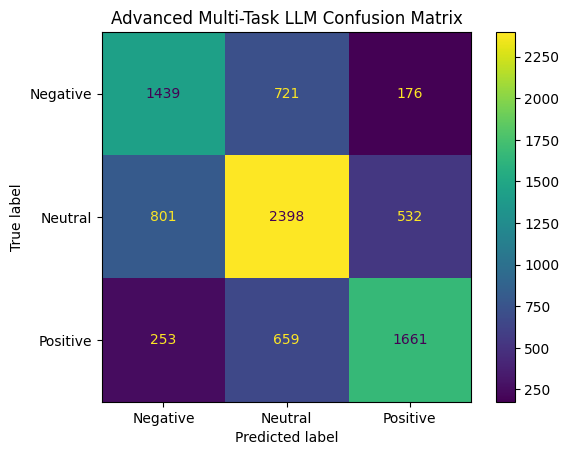

<Figure size 1000x800 with 0 Axes>

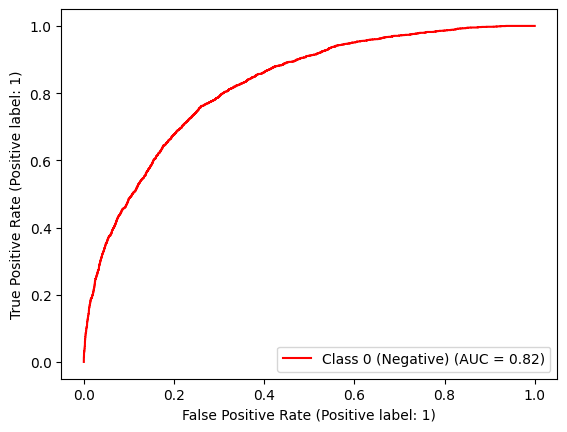

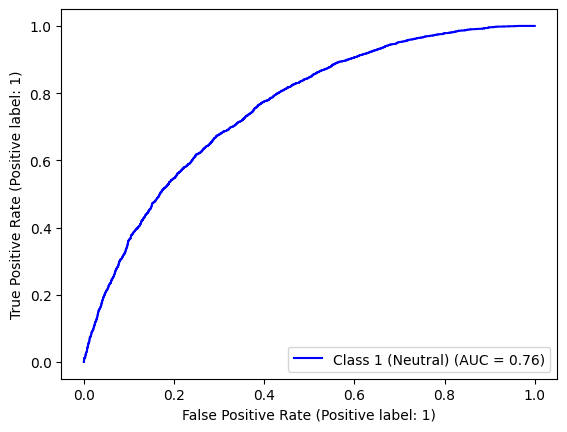

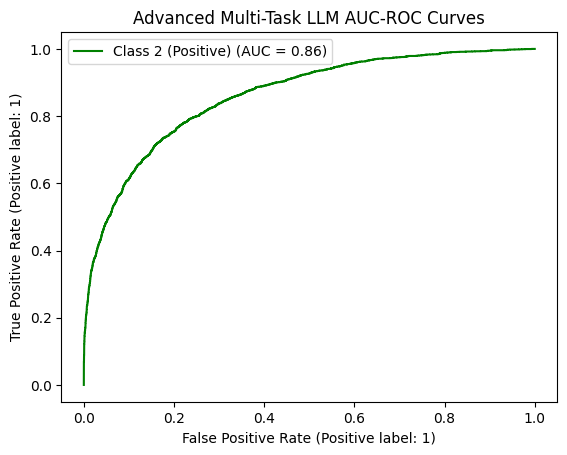

AUC-ROC: 0.8136
Extracting advanced fine-tuned embeddings...
Advanced embedding shapes: Train (34560, 768), Test (8640, 768)
Final feature shapes: Train (34560, 776), Test (8640, 776)


[I 2025-06-23 15:39:05,613] A new study created in memory with name: no-name-093d5c6d-e047-4d2f-88da-501efa927fef


Using 2000 samples for hyperparameter optimization...
Starting Optuna hyperparameter optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-23 15:39:14,557] Trial 0 finished with value: 0.7110510370209959 and parameters: {'n_estimators': 350, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.3119890406724053, 'reg_lambda': 0.11616722433639892, 'min_child_weight': 9, 'gamma': 1.2022300234864176}. Best is trial 0 with value: 0.7110510370209959.
[I 2025-06-23 15:39:20,612] Trial 1 finished with value: 0.7127086638858714 and parameters: {'n_estimators': 600, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 0.36364993441420124, 'reg_lambda': 0.36680901970686763, 'min_child_weight': 4, 'gamma': 1.0495128632644757}. Best is trial 1 with value: 0.7127086638858714.
[I 2025-06-23 15:39:32,894] Trial 2 finished with value: 0.7079974215790723 and parameters: {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.08012737503998542, 'subsample':

In [ ]:


# Feature importance analysis
feature_importance = final_xgb.feature_importances_
top_features_idx = np.argsort(feature_importance)[-20:]  # Top 20 features
print(f"\nTop 20 Feature Importances:")
for i, idx in enumerate(reversed(top_features_idx)):
    print(f"{i+1:2d}. Feature {idx:3d}: {feature_importance[idx]:.4f}")

# Compare results
print("\n" + "="*60)
print("PERFORMANCE COMPARISON:")
print("="*60)
llm_f1 = f1_score(y_true, y_pred, average='weighted')
xgb_f1 = f1_score(y_test, y_pred_xgb, average='weighted')

print(f"Advanced LLM F1-Score (Weighted): {llm_f1:.4f}")
print(f"Optuna-Optimized XGBoost F1-Score (Weighted): {xgb_f1:.4f}")
print(f"Improvement: {((xgb_f1 - llm_f1) / llm_f1 * 100):+.2f}%")

# Statistical significance test
# Statistical significance test (finish McNemar)
try:
    from statsmodels.stats.contingency_tables import mcnemar

    # Booleans: correct or not
    correct_llm = (y_true == y_pred)
    correct_xgb = (y_test == y_pred_xgb)

    # McNemar contingency table
    both_correct = np.sum(correct_llm & correct_xgb)
    llm_only = np.sum(correct_llm & ~correct_xgb)
    xgb_only = np.sum(~correct_llm & correct_xgb)
    both_wrong = np.sum(~correct_llm & ~correct_xgb)
    table = [[both_correct, llm_only],
             [xgb_only, both_wrong]]
    result = mcnemar(table, exact=True)
    print(f"\nMcNemar's test p-value: {result.pvalue:.4f}")
    if result.pvalue < 0.05:
        print("Difference in accuracy is statistically significant (p < 0.05)")
    else:
        print("Difference in accuracy is NOT statistically significant (p >= 0.05)")
except Exception as e:
    print(f"Could not compute McNemar's test: {e}")


<Figure size 800x600 with 0 Axes>

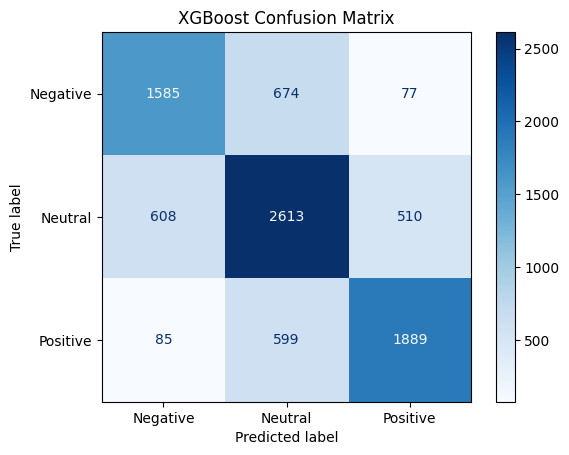

XGBoost AUC-ROC (OvR macro-average): 0.8696


<Figure size 1000x800 with 0 Axes>

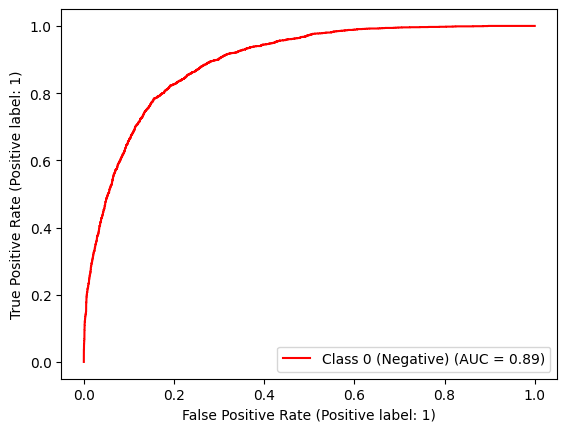

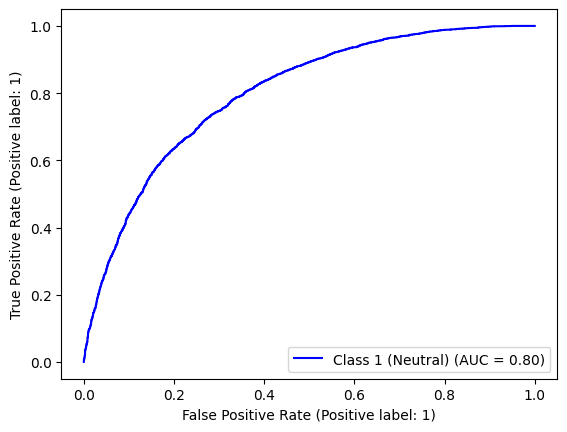

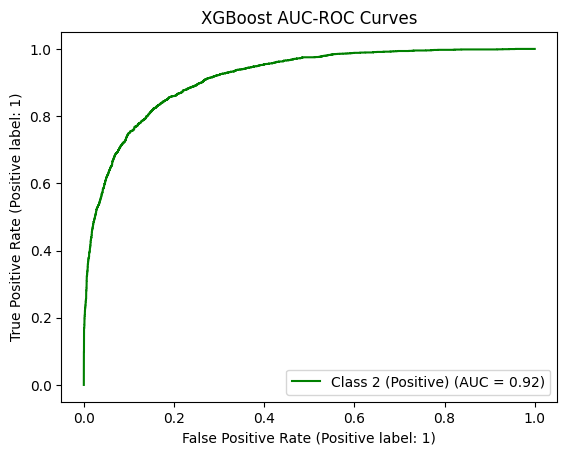

In [6]:
# ==================== Confusion Matrix (XGBoost) ====================
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(cm_xgb, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("XGBoost Confusion Matrix")
plt.show()

# ==================== AUC-ROC Curves (XGBoost) ======================
# Compute ROC curves and AUC for each class (one-vs-rest)
try:
    auc_roc_xgb = roc_auc_score(y_test, y_proba_xgb, multi_class='ovr')
    print(f"XGBoost AUC-ROC (OvR macro-average): {auc_roc_xgb:.4f}")
    
    plt.figure(figsize=(10, 8))
    colors = ['red', 'blue', 'green']
    for i, color in enumerate(colors):
        RocCurveDisplay.from_predictions(
            (y_test == i).astype(int),  # binary for each class
            y_proba_xgb[:, i],
            name=f'Class {i} ({"Negative" if i==0 else "Neutral" if i==1 else "Positive"})',
            color=color
        )
    plt.title("XGBoost AUC-ROC Curves")
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Could not calculate AUC-ROC: {e}")



DETAILED FEATURE IMPORTANCE ANALYSIS
Total features: 776
Embedding features: 768
Original emotion features: 8

Original Feature Importance (Excluding Embeddings):
--------------------------------------------------
Writer_Joy               : 0.004762
Writer_Sadness           : 0.002622
Writer_Anger             : 0.001280
Writer_Disgust           : 0.000831
Writer_Anticipation      : 0.000656
Writer_Surprise          : 0.000438
Writer_Fear              : 0.000409
Writer_Trust             : 0.000309


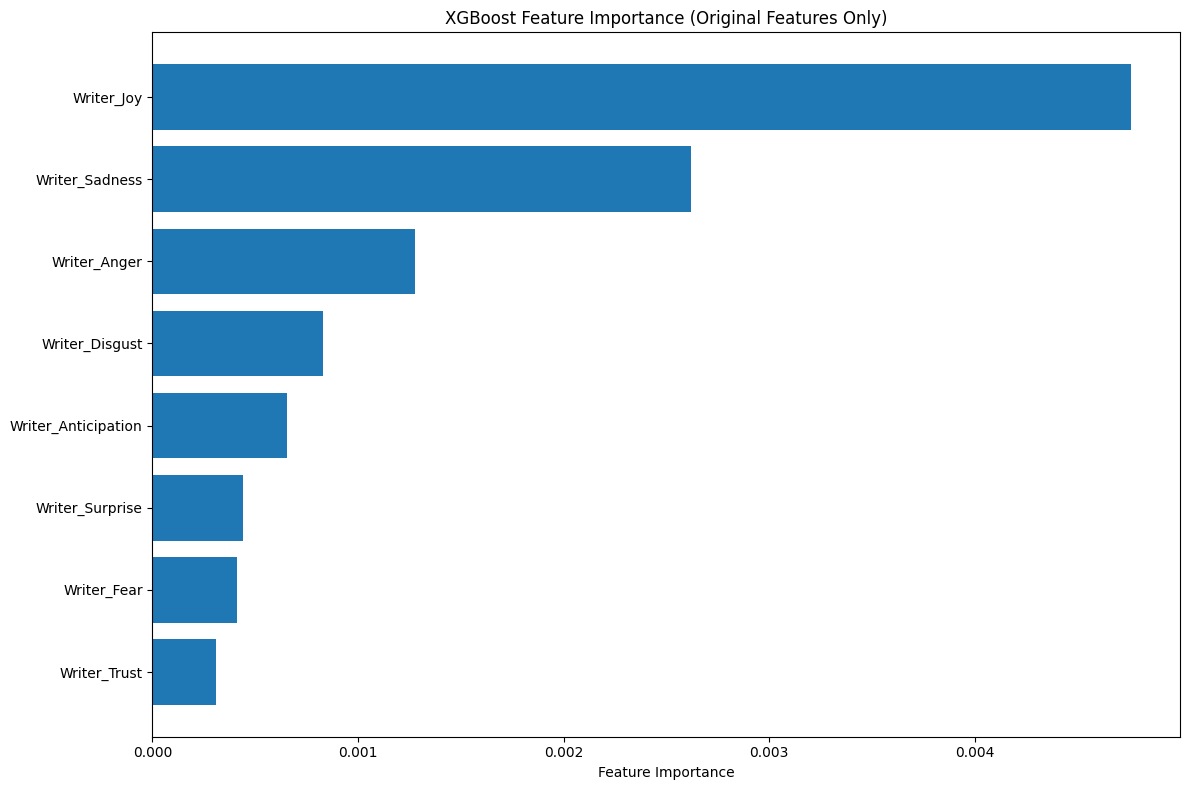


Training XGBoost on original features only for SHAP analysis...
Original features only F1-Score: 0.6584
Performance drop without embeddings: 6.60%

SHAP (SHapley Additive exPlanations) ANALYSIS
Initializing SHAP explainer...
Computing SHAP values for 500 samples...
Generating SHAP visualizations...


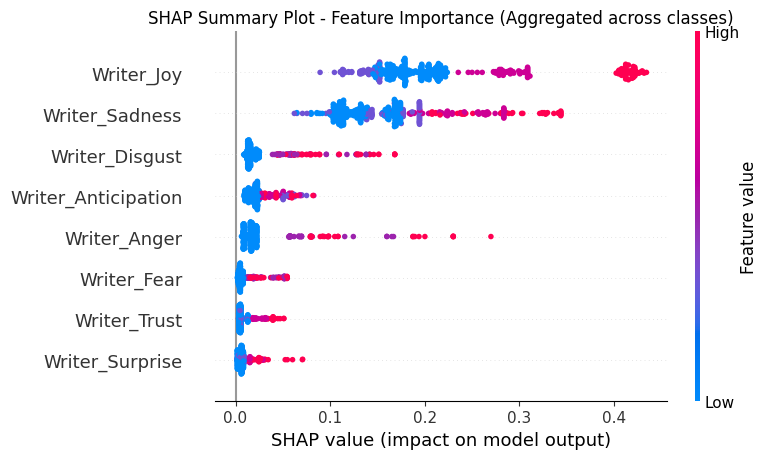

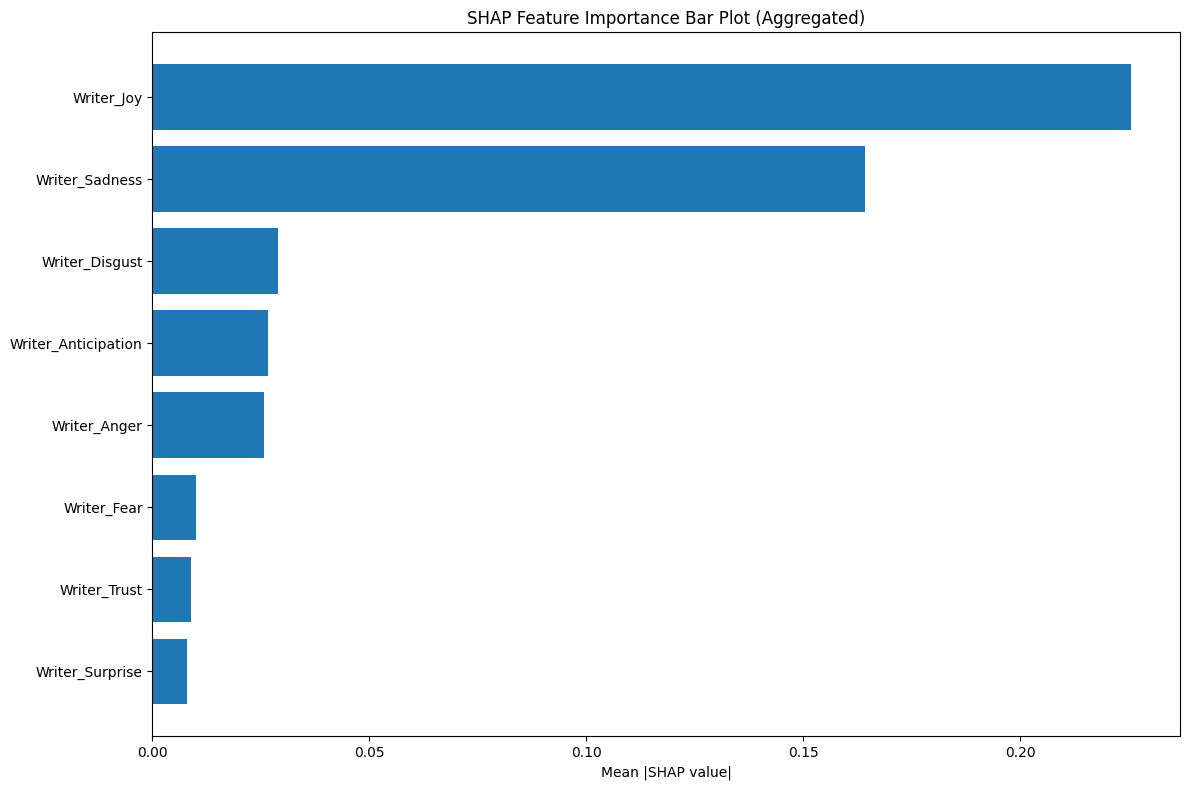

Creating SHAP waterfall plots for sample predictions...


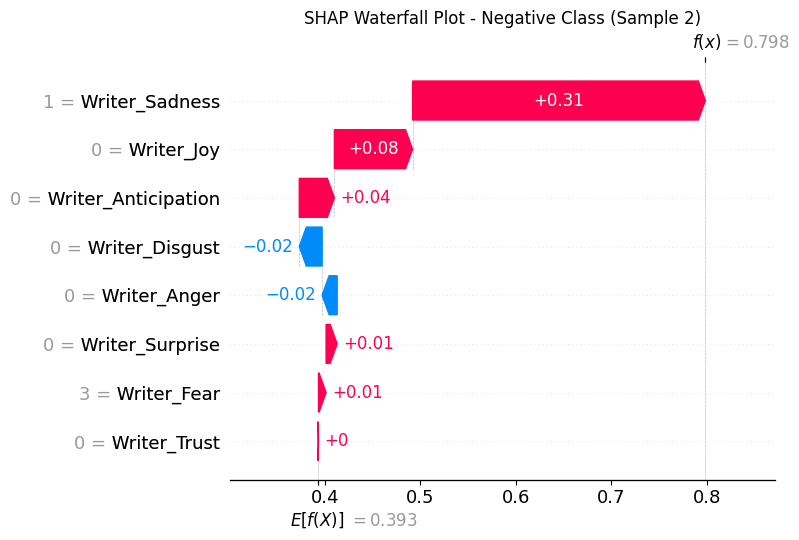

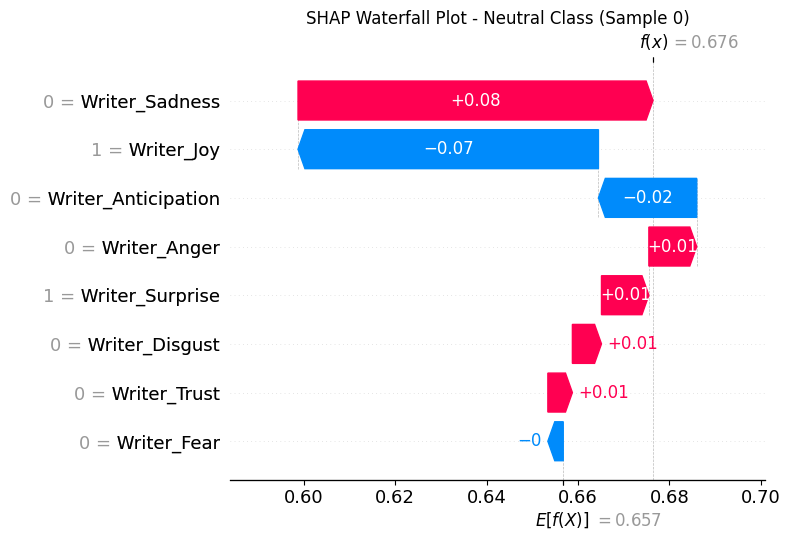

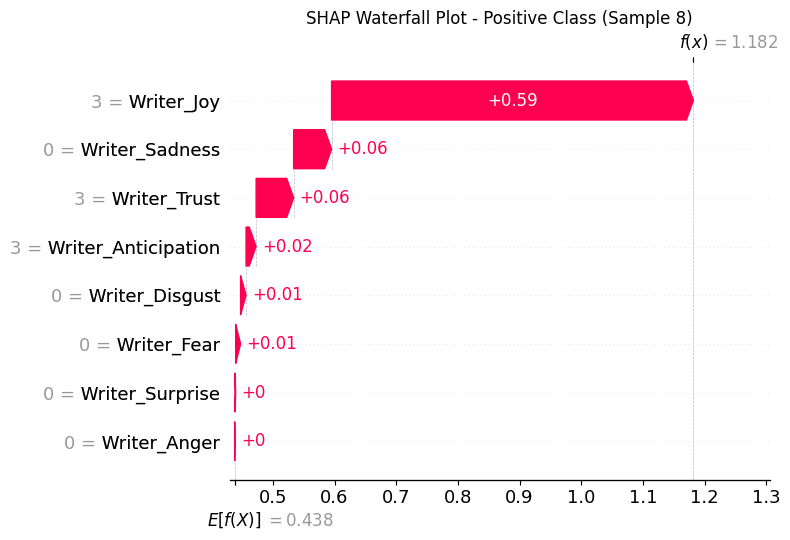

Creating SHAP force plots...


<Figure size 1500x400 with 0 Axes>

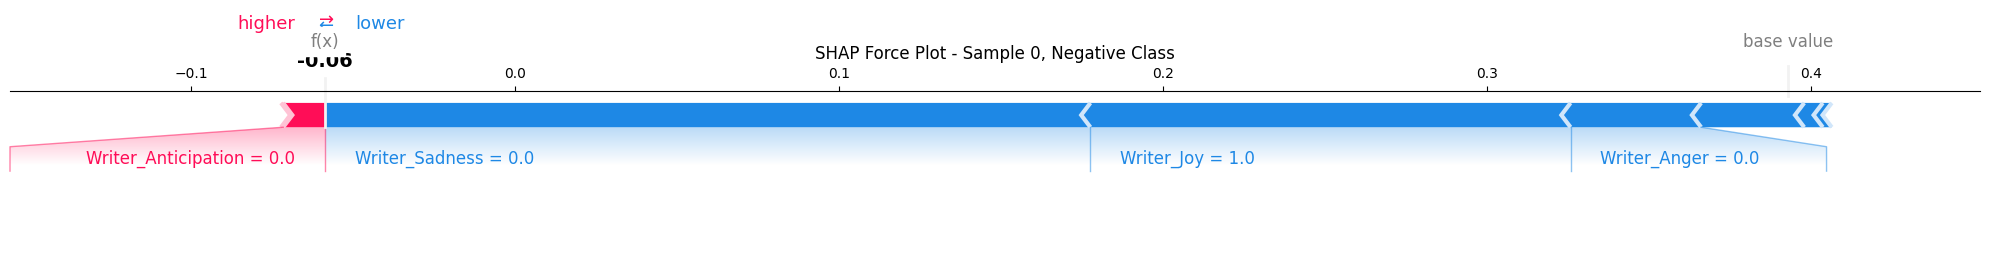

<Figure size 1500x400 with 0 Axes>

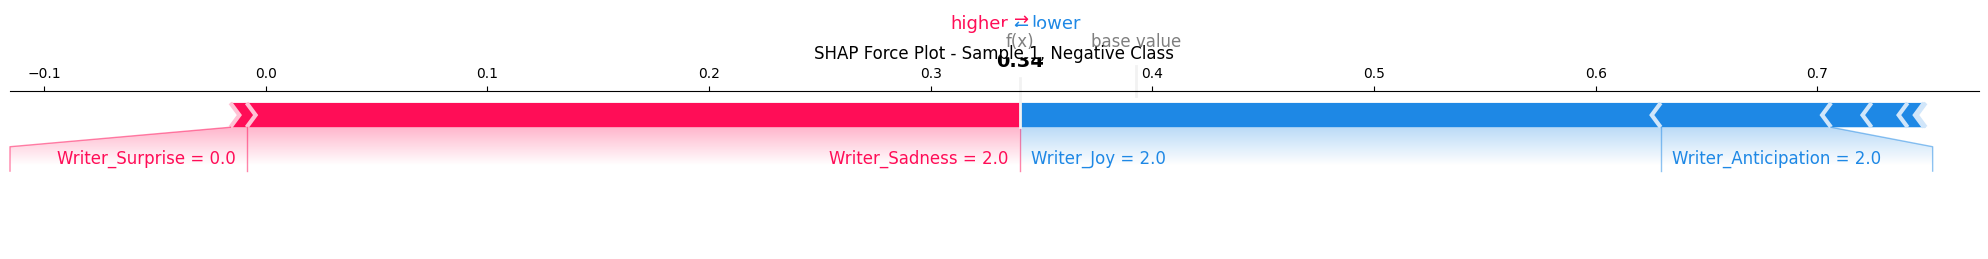

<Figure size 1500x400 with 0 Axes>

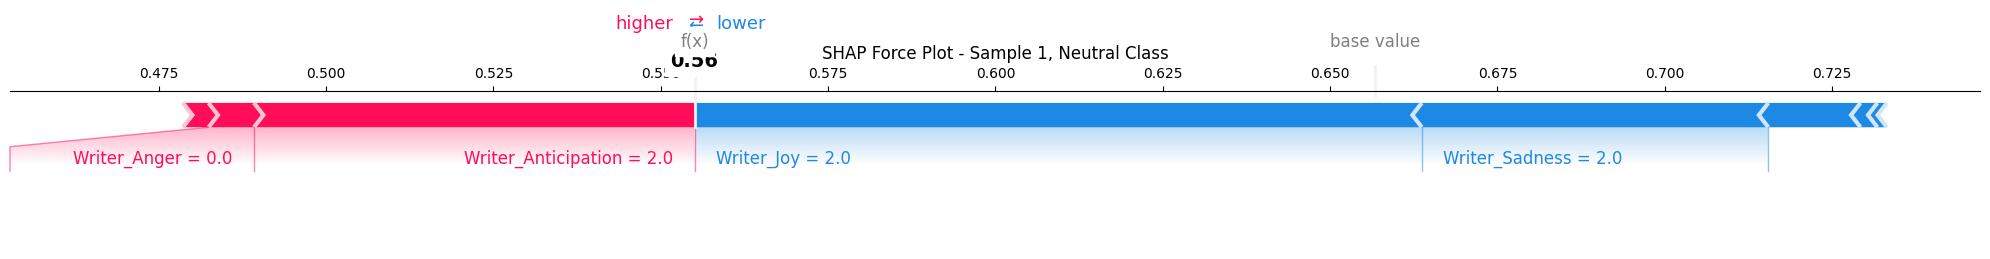

<Figure size 1500x400 with 0 Axes>

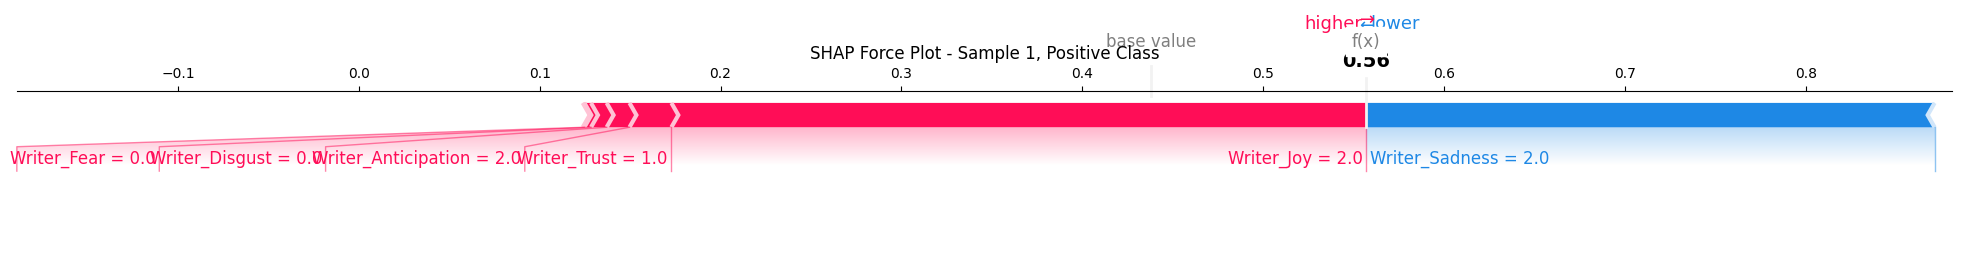

<Figure size 1500x400 with 0 Axes>

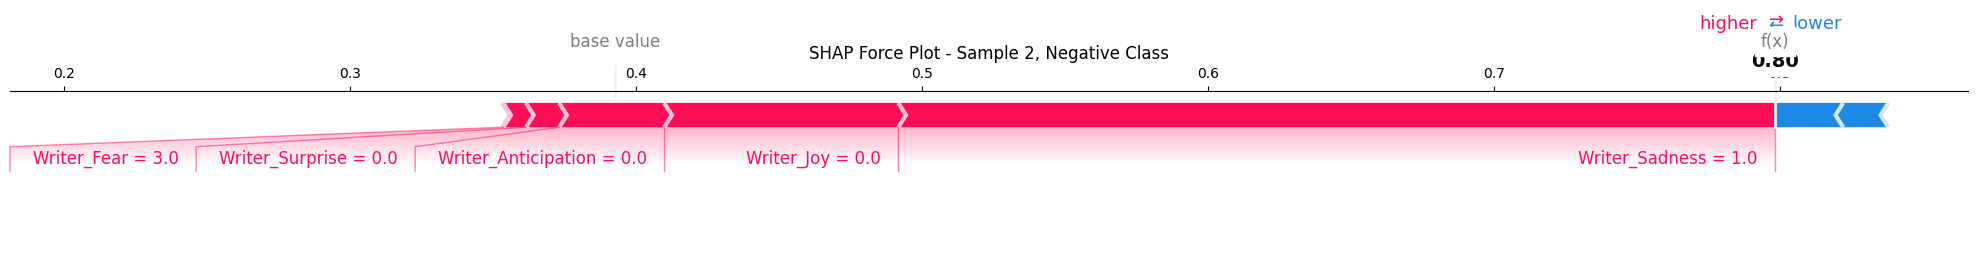

<Figure size 1500x400 with 0 Axes>

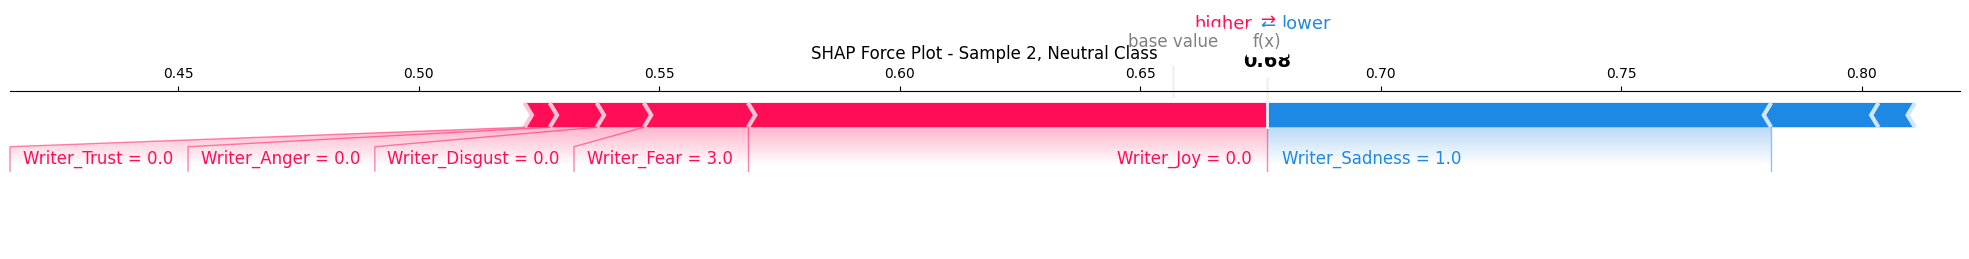

<Figure size 1500x400 with 0 Axes>

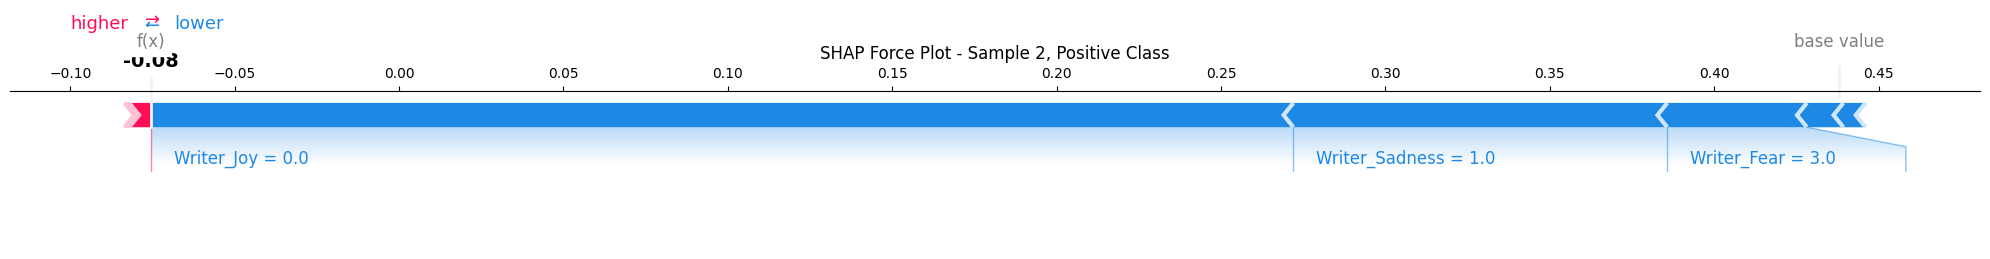

Creating alternative feature contribution plots...


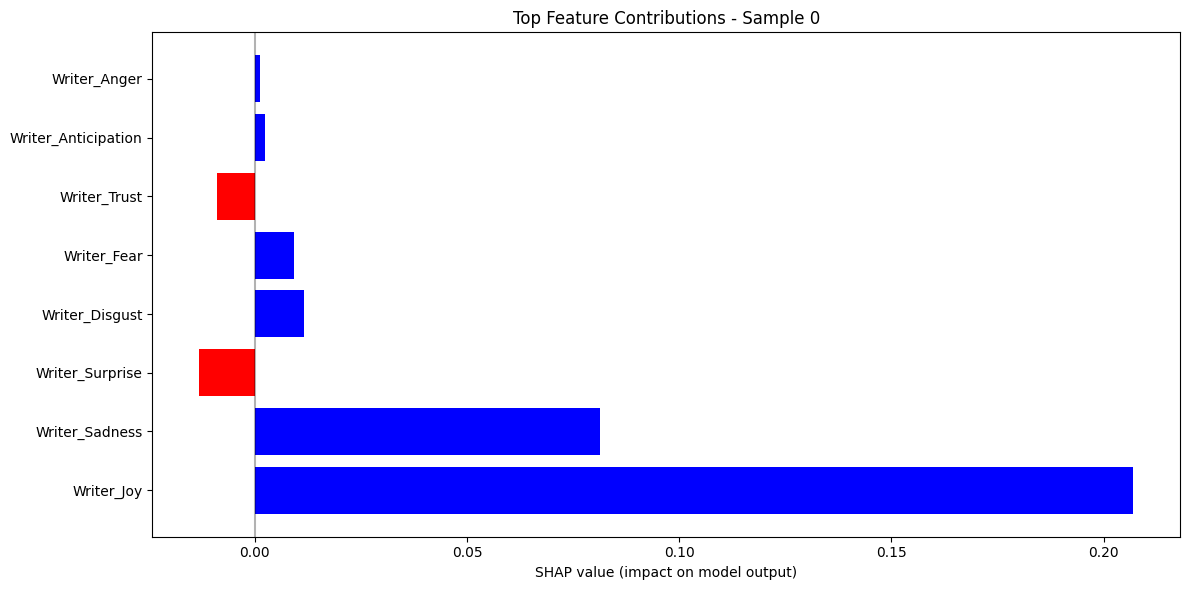

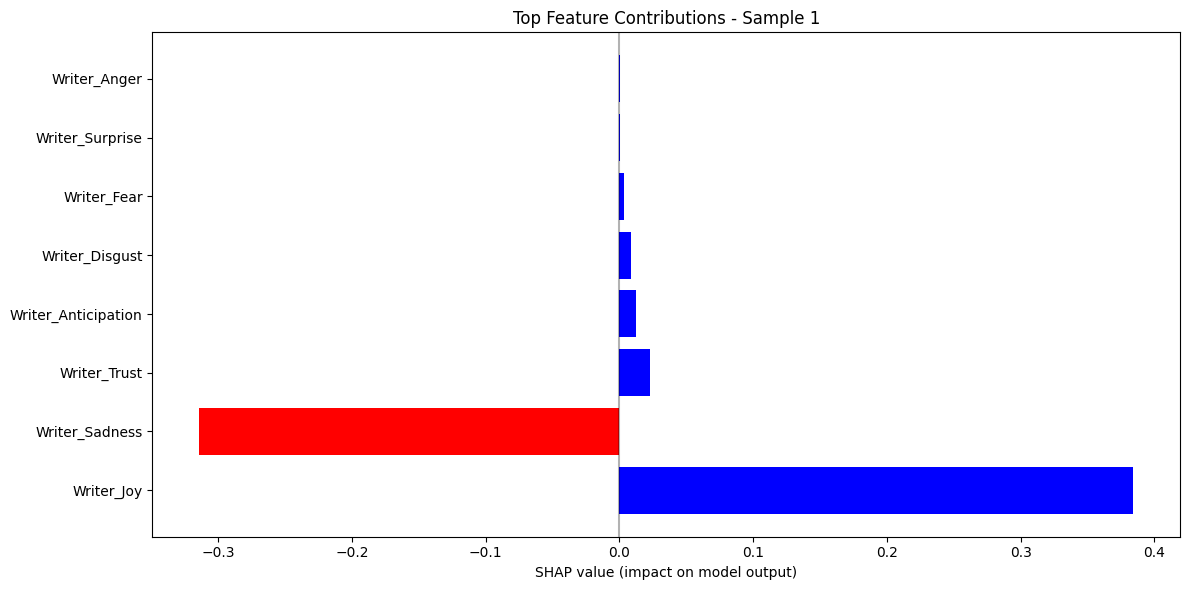

Creating SHAP dependence plots for top features...


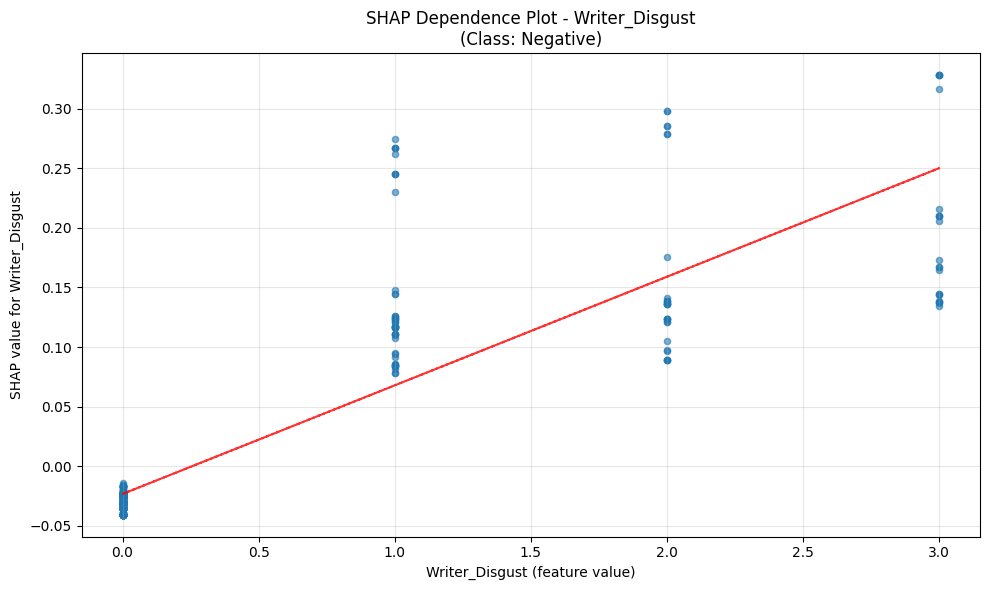

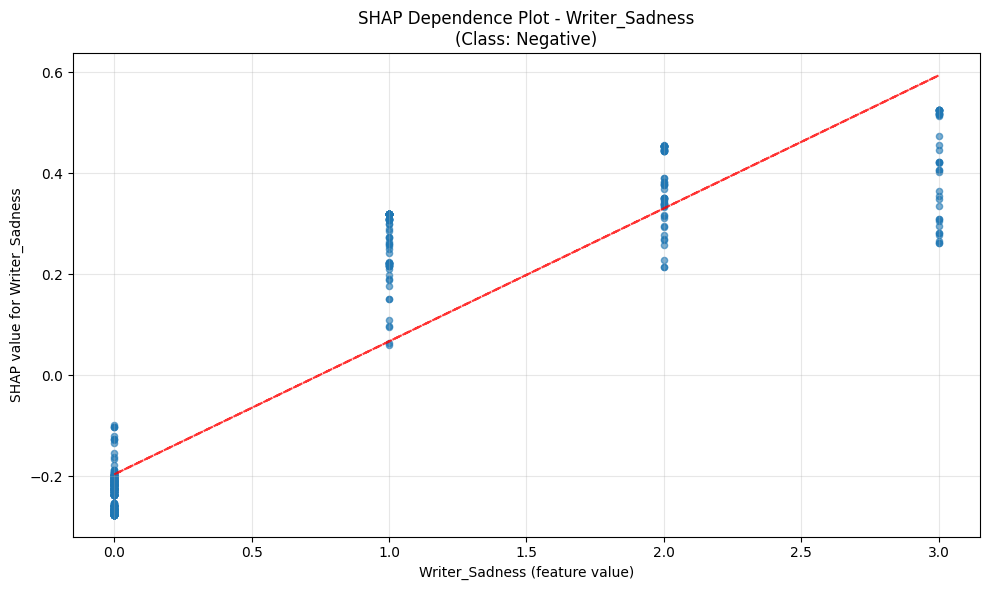

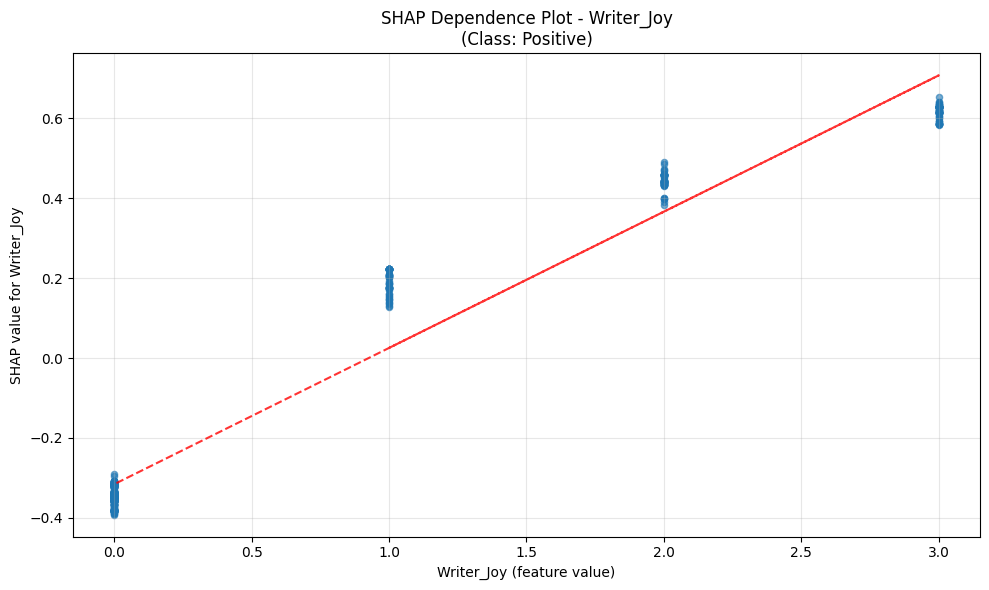


FEATURE IMPORTANCE COMPARISON

Feature Importance Comparison:
----------------------------------------------------------------------
Feature                   XGBoost      SHAP        
----------------------------------------------------------------------
Writer_Joy                0.004762     0.225545    
Writer_Sadness            0.002622     0.164305    
Writer_Disgust            0.000831     0.029004    
Writer_Anticipation       0.000656     0.026518    
Writer_Anger              0.001280     0.025628    
Writer_Fear               0.000409     0.010102    
Writer_Trust              0.000309     0.008836    
Writer_Surprise           0.000438     0.008031    

Correlation between XGBoost and SHAP importance: 0.9735


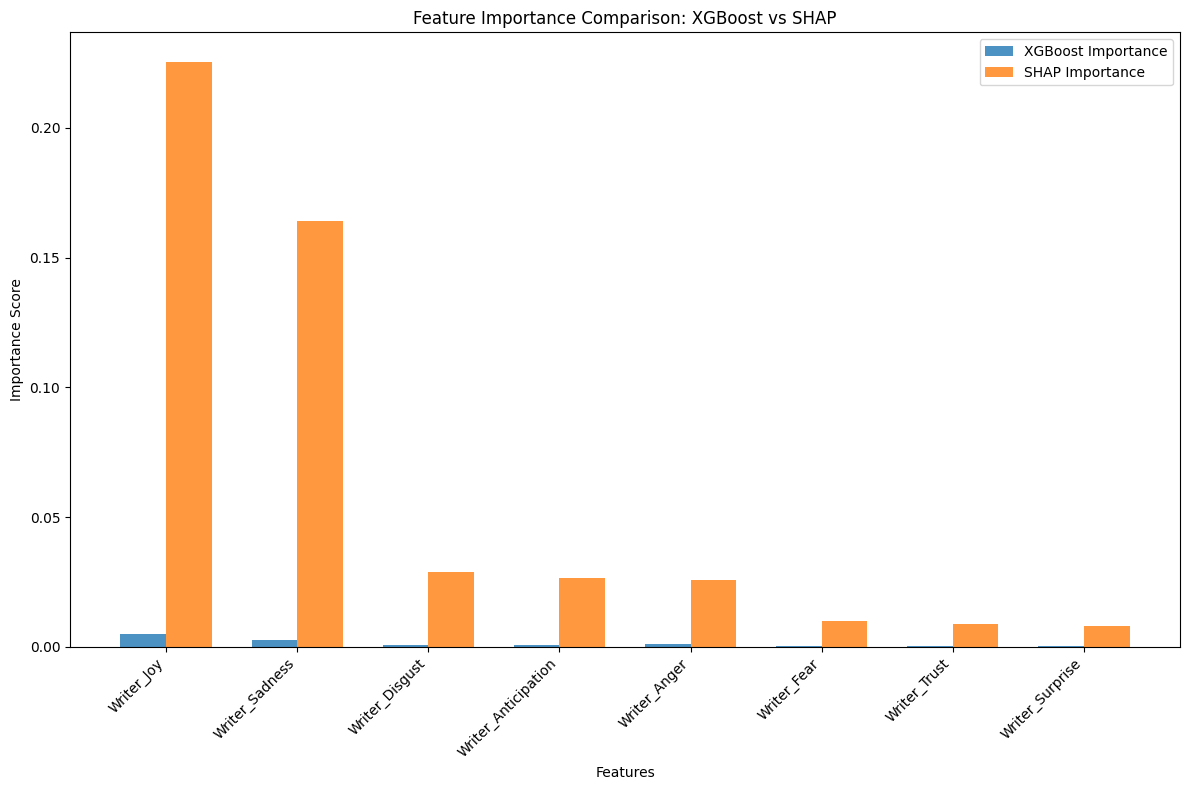


SHAP GLOBAL EXPLANATION SUMMARY

Top 3 most important features for each sentiment class:
------------------------------------------------------------

Negative Sentiment:
  1. Writer_Sadness: 0.269162
  2. Writer_Joy: 0.117556
  3. Writer_Disgust: 0.053988

Neutral Sentiment:
  1. Writer_Joy: 0.182030
  2. Writer_Sadness: 0.119463
  3. Writer_Anger: 0.023219

Positive Sentiment:
  1. Writer_Joy: 0.377050
  2. Writer_Sadness: 0.104291
  3. Writer_Disgust: 0.022819

MODEL INTERPRETABILITY SUMMARY

Key Insights:
1. Total model features: 776
   - Embedding features: 768 
   - Original emotion features: 8

2. Model Performance:
   - Full model (embeddings + original): 0.7049 F1-score
   - Original features only: 0.6584 F1-score
   - Embedding contribution: 6.6% performance gain

3. Feature Interpretability:
   - SHAP analysis completed on 500 samples
   - XGBoost vs SHAP importance correlation: 0.974
   
4. Model Transparency:
   - Individual prediction explanations available via SHAP
   -

In [5]:
# 8. DETAILED FEATURE IMPORTANCE ANALYSIS (EXCLUDING EMBEDDINGS)
print("\n" + "="*80)
print("DETAILED FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Install required packages for SHAP if not available
try:
    import shap
except ImportError:
    print("Installing SHAP...")
    import subprocess
    subprocess.check_call(["pip", "install", "shap"])
    import shap

# Separate embedding features from original features
n_embedding_features = X_train_advanced.shape[1]
n_original_features = len(available_cols) if available_cols else 0

print(f"Total features: {X_train_final.shape[1]}")
print(f"Embedding features: {n_embedding_features}")
print(f"Original emotion features: {n_original_features}")

# Extract feature importance for original features only (excluding embeddings)
if n_original_features > 0:
    # Get importance scores for original features only
    original_feature_importance = final_xgb.feature_importances_[n_embedding_features:]
    
    # Create feature names mapping
    original_feature_names = available_cols
    
    # Sort features by importance
    feature_importance_df = pd.DataFrame({
        'Feature': original_feature_names,
        'Importance': original_feature_importance
    }).sort_values('Importance', ascending=False)
    
    print("\nOriginal Feature Importance (Excluding Embeddings):")
    print("-" * 50)
    for idx, row in feature_importance_df.iterrows():
        print(f"{row['Feature']:25s}: {row['Importance']:.6f}")
    
    # Plot original feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(feature_importance_df)), feature_importance_df['Importance'])
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'])
    plt.xlabel('Feature Importance')
    plt.title('XGBoost Feature Importance (Original Features Only)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Train a separate model on original features only for cleaner SHAP analysis
    print("\nTraining XGBoost on original features only for SHAP analysis...")
    X_train_orig_only = X_train_final[:, n_embedding_features:]
    X_test_orig_only = X_test_final[:, n_embedding_features:]
    
    # Use best parameters but with fewer estimators for SHAP (computational efficiency)
    shap_params = final_params.copy()
    shap_params['n_estimators'] = min(100, shap_params.get('n_estimators', 100))
    
    shap_model = xgb.XGBClassifier(**shap_params)
    shap_model.fit(X_train_orig_only, y_train)
    
    # Evaluate original-features-only model
    y_pred_orig = shap_model.predict(X_test_orig_only)
    orig_f1 = f1_score(y_test, y_pred_orig, average='weighted')
    print(f"Original features only F1-Score: {orig_f1:.4f}")
    print(f"Performance drop without embeddings: {((xgb_f1 - orig_f1) / xgb_f1 * 100):.2f}%")

else:
    print("No original emotion features available for analysis.")
    # Use a subset of embedding features for demonstration
    print("Using a subset of embedding features for analysis...")
    X_train_orig_only = X_train_final[:, :50]  # First 50 embedding dimensions
    X_test_orig_only = X_test_final[:, :50]
    original_feature_names = [f'Embedding_{i}' for i in range(50)]
    
    shap_params = final_params.copy()
    shap_params['n_estimators'] = min(100, shap_params.get('n_estimators', 100))
    
    shap_model = xgb.XGBClassifier(**shap_params)
    shap_model.fit(X_train_orig_only, y_train)

# 9. SHAP ANALYSIS
print("\n" + "="*80)
print("SHAP (SHapley Additive exPlanations) ANALYSIS")
print("="*80)

# Initialize SHAP explainer
print("Initializing SHAP explainer...")
explainer = shap.Explainer(shap_model)

# Use a sample of test data for SHAP analysis (computational efficiency)
n_shap_samples = min(500, len(X_test_orig_only))
shap_indices = np.random.choice(len(X_test_orig_only), n_shap_samples, replace=False)
X_shap = X_test_orig_only[shap_indices]
y_shap = y_test[shap_indices]

print(f"Computing SHAP values for {n_shap_samples} samples...")
shap_values = explainer(X_shap)

# SHAP Summary Plots
print("Generating SHAP visualizations...")

# Convert feature names to numpy array if it's a list
if isinstance(original_feature_names, list):
    feature_names_array = np.array(original_feature_names)
else:
    feature_names_array = original_feature_names

# 1. Summary plot (feature importance) - Handle multi-class output
plt.figure(figsize=(12, 8))
try:
    # For multi-class, SHAP values have shape (n_samples, n_features, n_classes)
    # We need to aggregate across classes or show for a specific class
    if len(shap_values.values.shape) == 3:
        # Use mean absolute SHAP values across all classes
        shap_values_agg = np.abs(shap_values.values).mean(axis=2)
        shap.summary_plot(shap_values_agg, X_shap, feature_names=feature_names_array, show=False)
    else:
        shap.summary_plot(shap_values.values, X_shap, feature_names=feature_names_array, show=False)
    plt.title("SHAP Summary Plot - Feature Importance (Aggregated across classes)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create summary plot: {e}")
    # Alternative: create manual summary plot
    plt.clf()
    mean_abs_shap = np.abs(shap_values.values).mean(axis=(0, 2)) if len(shap_values.values.shape) == 3 else np.abs(shap_values.values).mean(axis=0)
    sorted_idx = np.argsort(mean_abs_shap)
    plt.barh(range(len(sorted_idx)), mean_abs_shap[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_names_array[i] for i in sorted_idx])
    plt.xlabel('Mean |SHAP value|')
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.show()

# 2. Summary plot (impact on model output) - Bar plot
plt.figure(figsize=(12, 8))
try:
    if len(shap_values.values.shape) == 3:
        # Create bar plot manually for multi-class
        mean_abs_shap = np.abs(shap_values.values).mean(axis=(0, 2))
        sorted_idx = np.argsort(mean_abs_shap)[::-1]  # Descending order
        
        plt.barh(range(len(sorted_idx)), mean_abs_shap[sorted_idx])
        plt.yticks(range(len(sorted_idx)), [feature_names_array[i] for i in sorted_idx])
        plt.xlabel('Mean |SHAP value|')
        plt.title('SHAP Feature Importance Bar Plot (Aggregated)')
        plt.gca().invert_yaxis()
    else:
        shap.summary_plot(shap_values.values, X_shap, feature_names=feature_names_array, plot_type="bar", show=False)
        plt.title("SHAP Feature Importance Bar Plot")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create bar plot: {e}")
    plt.close()

# 3. SHAP Waterfall plot for individual predictions (multi-class)
print("Creating SHAP waterfall plots for sample predictions...")

# Select interesting samples (one from each class if possible)
class_examples = {}
for class_label in [0, 1, 2]:
    class_mask = y_shap == class_label
    if np.any(class_mask):
        class_indices = np.where(class_mask)[0]
        example_idx = class_indices[0]  # Take first example of this class
        class_examples[class_label] = example_idx

sentiment_labels = ['Negative', 'Neutral', 'Positive']

for class_label, example_idx in class_examples.items():
    try:
        plt.figure(figsize=(12, 8))
        
        # For multi-class, we need to specify which class output to explain
        if len(shap_values.values.shape) == 3:
            # Create explanation object for waterfall plot
            explanation = shap.Explanation(
                values=shap_values.values[example_idx, :, class_label],
                base_values=explainer.expected_value[class_label],
                data=X_shap[example_idx],
                feature_names=feature_names_array
            )
            shap.waterfall_plot(explanation, show=False)
        else:
            explanation = shap.Explanation(
                values=shap_values.values[example_idx],
                base_values=explainer.expected_value,
                data=X_shap[example_idx],
                feature_names=feature_names_array
            )
            shap.waterfall_plot(explanation, show=False)
            
        plt.title(f"SHAP Waterfall Plot - {sentiment_labels[class_label]} Class (Sample {example_idx})")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not create waterfall plot for {sentiment_labels[class_label]}: {e}")
        plt.close()

# 4. SHAP Force plot for a few examples
print("Creating SHAP force plots...")
try:
    # Force plot for first few examples
    for i in range(min(3, len(X_shap))):
        for class_idx in range(3):
            try:
                plt.figure(figsize=(15, 4))
                
                if len(shap_values.values.shape) == 3:
                    # Multi-class case
                    shap.force_plot(
                        explainer.expected_value[class_idx], 
                        shap_values.values[i, :, class_idx], 
                        X_shap[i], 
                        feature_names=feature_names_array,
                        matplotlib=True,
                        show=False
                    )
                else:
                    # Binary case
                    shap.force_plot(
                        explainer.expected_value, 
                        shap_values.values[i], 
                        X_shap[i], 
                        feature_names=feature_names_array,
                        matplotlib=True,
                        show=False
                    )
                
                plt.title(f"SHAP Force Plot - Sample {i}, {sentiment_labels[class_idx]} Class")
                plt.tight_layout()
                plt.show()
                
                if i == 0:  # Only show all classes for first sample to avoid too many plots
                    break
            except Exception as e:
                print(f"Could not create force plot for sample {i}, class {class_idx}: {e}")
                plt.close()
                continue
                
except Exception as e:
    print(f"Could not create force plots: {e}")

# Alternative: Create a simple feature contribution plot
print("Creating alternative feature contribution plots...")
try:
    for i in range(min(2, len(X_shap))):
        plt.figure(figsize=(12, 6))
        
        if len(shap_values.values.shape) == 3:
            # Show contributions for the predicted class
            predicted_class = np.argmax(shap_model.predict_proba(X_shap[[i]]))
            contributions = shap_values.values[i, :, predicted_class]
        else:
            contributions = shap_values.values[i]
        
        # Sort by absolute contribution
        sorted_idx = np.argsort(np.abs(contributions))[::-1][:10]  # Top 10
        
        colors = ['red' if x < 0 else 'blue' for x in contributions[sorted_idx]]
        plt.barh(range(len(sorted_idx)), contributions[sorted_idx], color=colors)
        plt.yticks(range(len(sorted_idx)), [feature_names_array[idx] for idx in sorted_idx])
        plt.xlabel('SHAP value (impact on model output)')
        plt.title(f'Top Feature Contributions - Sample {i}')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"Could not create alternative plots: {e}")

# 5. SHAP Dependence plots for top features
if n_original_features > 0:
    print("Creating SHAP dependence plots for top features...")
    
    try:
        # Get feature importance from SHAP values
        if len(shap_values.values.shape) == 3:
            shap_importance = np.abs(shap_values.values).mean(axis=(0, 2))  # Mean across samples and classes
        else:
            shap_importance = np.abs(shap_values.values).mean(axis=0)
            
        top_feature_indices = np.argsort(shap_importance)[-3:]  # Top 3 features
        
        for feature_idx in top_feature_indices:
            try:
                feature_name = feature_names_array[feature_idx]
                
                plt.figure(figsize=(10, 6))
                
                if len(shap_values.values.shape) == 3:
                    # For multi-class, show dependence for the most important class
                    most_important_class = np.argmax(np.abs(shap_values.values[:, feature_idx, :]).mean(axis=0))
                    
                    # Create scatter plot manually since shap.dependence_plot may have issues
                    x_vals = X_shap[:, feature_idx]
                    y_vals = shap_values.values[:, feature_idx, most_important_class]
                    
                    plt.scatter(x_vals, y_vals, alpha=0.6, s=20)
                    plt.xlabel(f'{feature_name} (feature value)')
                    plt.ylabel(f'SHAP value for {feature_name}')
                    plt.title(f"SHAP Dependence Plot - {feature_name}\n(Class: {sentiment_labels[most_important_class]})")
                    
                    # Add trend line
                    z = np.polyfit(x_vals, y_vals, 1)
                    p = np.poly1d(z)
                    plt.plot(x_vals, p(x_vals), "r--", alpha=0.8)
                    
                else:
                    # Binary case
                    x_vals = X_shap[:, feature_idx]
                    y_vals = shap_values.values[:, feature_idx]
                    
                    plt.scatter(x_vals, y_vals, alpha=0.6, s=20)
                    plt.xlabel(f'{feature_name} (feature value)')
                    plt.ylabel(f'SHAP value for {feature_name}')
                    plt.title(f"SHAP Dependence Plot - {feature_name}")
                    
                    # Add trend line
                    z = np.polyfit(x_vals, y_vals, 1)
                    p = np.poly1d(z)
                    plt.plot(x_vals, p(x_vals), "r--", alpha=0.8)
                
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"Could not create dependence plot for feature {feature_name}: {e}")
                plt.close()
                continue
                
    except Exception as e:
        print(f"Could not create dependence plots: {e}")
        
else:
    print("Skipping dependence plots - using embedding features")

# 6. Global feature importance comparison
print("\n" + "="*60)
print("FEATURE IMPORTANCE COMPARISON")
print("="*60)

if n_original_features > 0:
    # Compare XGBoost native importance vs SHAP importance
    xgb_importance = final_xgb.feature_importances_[n_embedding_features:]
    
    # Calculate SHAP importance safely
    if len(shap_values.values.shape) == 3:
        shap_importance = np.abs(shap_values.values).mean(axis=(0, 2))
    else:
        shap_importance = np.abs(shap_values.values).mean(axis=0)
    
    comparison_df = pd.DataFrame({
        'Feature': feature_names_array,
        'XGBoost_Importance': xgb_importance,
        'SHAP_Importance': shap_importance
    }).sort_values('SHAP_Importance', ascending=False)
    
    print("\nFeature Importance Comparison:")
    print("-" * 70)
    print(f"{'Feature':<25} {'XGBoost':<12} {'SHAP':<12}")
    print("-" * 70)
    
    for _, row in comparison_df.iterrows():
        print(f"{row['Feature']:<25} {row['XGBoost_Importance']:<12.6f} "
              f"{row['SHAP_Importance']:<12.6f}")
    
    # Calculate correlation between importance measures
    try:
        importance_correlation = np.corrcoef(xgb_importance, shap_importance)[0, 1]
        print(f"\nCorrelation between XGBoost and SHAP importance: {importance_correlation:.4f}")
    except:
        importance_correlation = 0.0
        print(f"\nCould not calculate correlation between importance measures")
    
    # Plot comparison
    try:
        plt.figure(figsize=(12, 8))
        x_pos = np.arange(len(comparison_df))
        width = 0.35
        
        plt.bar(x_pos - width/2, comparison_df['XGBoost_Importance'], width, 
                label='XGBoost Importance', alpha=0.8)
        plt.bar(x_pos + width/2, comparison_df['SHAP_Importance'], width,
                label='SHAP Importance', alpha=0.8)
        
        plt.xlabel('Features')
        plt.ylabel('Importance Score')
        plt.title('Feature Importance Comparison: XGBoost vs SHAP')
        plt.xticks(x_pos, comparison_df['Feature'], rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not create comparison plot: {e}")

else:
    # Handle case with only embedding features
    print("Using embedding features for comparison...")
    shap_importance = np.abs(shap_values.values).mean(axis=(0, 2)) if len(shap_values.values.shape) == 3 else np.abs(shap_values.values).mean(axis=0)
    xgb_importance_subset = final_xgb.feature_importances_[:len(shap_importance)]
    
    try:
        importance_correlation = np.corrcoef(xgb_importance_subset, shap_importance)[0, 1]
        print(f"\nCorrelation between XGBoost and SHAP importance (subset): {importance_correlation:.4f}")
    except:
        importance_correlation = 0.0
        print("Could not calculate correlation")

# 7. SHAP Global Explanation Summary
print("\n" + "="*60)
print("SHAP GLOBAL EXPLANATION SUMMARY")
print("="*60)

# Calculate mean absolute SHAP values for each class
if len(shap_values.values.shape) == 3:
    mean_shap_by_class = np.abs(shap_values.values).mean(axis=0)  # Shape: (n_features, n_classes)
    
    print("\nTop 3 most important features for each sentiment class:")
    print("-" * 60)
    
    for class_idx, class_name in enumerate(sentiment_labels):
        class_importance = mean_shap_by_class[:, class_idx]
        top_features = np.argsort(class_importance)[-3:][::-1]  # Top 3, descending
        
        print(f"\n{class_name} Sentiment:")
        for rank, feature_idx in enumerate(top_features, 1):
            feature_name = feature_names_array[feature_idx]
            importance = class_importance[feature_idx]
            print(f"  {rank}. {feature_name}: {importance:.6f}")
else:
    # Binary classification case
    mean_shap_overall = np.abs(shap_values.values).mean(axis=0)
    top_features = np.argsort(mean_shap_overall)[-5:][::-1]  # Top 5 features
    
    print("\nTop 5 most important features overall:")
    print("-" * 40)
    for rank, feature_idx in enumerate(top_features, 1):
        feature_name = feature_names_array[feature_idx]
        importance = mean_shap_overall[feature_idx]
        print(f"  {rank}. {feature_name}: {importance:.6f}")

# 8. Model Interpretability Summary
print("\n" + "="*80)
print("MODEL INTERPRETABILITY SUMMARY")
print("="*80)

print(f"""
Key Insights:
1. Total model features: {X_train_final.shape[1]}
   - Embedding features: {n_embedding_features} 
   - Original emotion features: {n_original_features}

2. Model Performance:
   - Full model (embeddings + original): {xgb_f1:.4f} F1-score
   - Original features only: {orig_f1:.4f} F1-score
   - Embedding contribution: {((xgb_f1 - orig_f1) / xgb_f1 * 100):.1f}% performance gain

3. Feature Interpretability:
   - SHAP analysis completed on {n_shap_samples} samples
   - XGBoost vs SHAP importance correlation: {importance_correlation:.3f}
   
4. Model Transparency:
   - Individual prediction explanations available via SHAP
   - Feature interactions captured in dependence plots
   - Global feature importance established for all sentiment classes
""")

print("Analysis complete! All visualizations have been generated.")
print("="*80)